In [ ]:
#Step 1 - convert HR data to HRV
import pandas as pd
import numpy as np
import os
from datetime import timedelta
import pyhrv.time_domain as td
import pyhrv.frequency_domain as fd


def compute_pnn(rr, threshold):
    rr_diff = np.abs(np.diff(rr))
    count_exceed = np.sum(rr_diff > threshold)
    return (count_exceed / len(rr_diff)) * 100 if len(rr_diff) > 0 else np.nan


def compute_time_and_freq_features(rr):
    rr_sec = rr / 1000.0  # convert to seconds
    td_res = td.time_domain(rr_sec, show=False)

    AVNN = td_res["nni_mean"] if td_res["nni_mean"] is not None else np.nan
    IHR = 60 / (AVNN / 1000) if AVNN else np.nan
    NN_RR = np.mean(rr)

    # Manual features
    pnn10 = compute_pnn(rr, 10)
    pnn20 = compute_pnn(rr, 20)
    pnn30 = compute_pnn(rr, 30)
    pnn40 = compute_pnn(rr, 40)
    pnn50 = compute_pnn(rr, 50)

    # Frequency features
    try:
        freq_res = fd.welch_psd(rr_sec, show=False)

        freq_dict = freq_res.as_dict()

        totpwr = freq_dict.get('fft_total', np.nan)

        fft_abs = freq_dict.get('fft_abs', (np.nan, np.nan, np.nan))
        fft_rel = freq_dict.get('fft_rel', (np.nan, np.nan, np.nan))
        fft_norm = freq_dict.get('fft_norm', (np.nan, np.nan))
        fft_ratio = freq_dict.get('fft_ratio', np.nan)

        # Absolute power in bands (VLF, LF, HF)
        vlf = fft_abs[0]
        lf = fft_abs[1]
        hf = fft_abs[2]

        # Relative power in bands (percentage)
        vlf_rel = fft_rel[0]
        lf_rel = fft_rel[1]
        hf_rel = fft_rel[2]

        # Normalized LF and HF power
        lf_n = fft_norm[0]
        hf_n = fft_norm[1]

        lf_hf = fft_ratio


    except Exception as e:
        print(f"⚠️ Welch PSD failed: {e}")
        print(f"RR stats → len: {len(rr_sec)}, min: {np.min(rr_sec)}, max: {np.max(rr_sec)}, std: {np.std(rr_sec)}")
        totpwr = vlf = lf = hf = lf_n = hf_n = lf_hf = np.nan


    return {
        "ihr": IHR,
        "NN_RR": NN_RR/1000,
        "AVNN": AVNN,
        "SDNN": td_res["sdnn"] if td_res["sdnn"] is not None else np.nan,
        "rMSSD": td_res["rmssd"] if td_res["rmssd"] is not None else np.nan,
        "PNN10": pnn10,
        "PNN20": pnn20,
        "PNN30": pnn30,
        "PNN40": pnn40,
        "PNN50": pnn50,
        "TOT_PWR": totpwr,
        "VLF": vlf,
        "LF": lf,
        "LF_n": lf_n/100,
        "HF": hf,
        "HF_n": hf_n/100,
        "LF_HF": lf_hf
    }


def transform_participant_to_shhs_format(cleaned_csv_path):
    df = pd.read_csv(cleaned_csv_path)

    # Add dummy timestamps for sliding window
    df["timestamp"] = pd.date_range(start='2020-01-01', periods=len(df), freq='30S')

    # Compute RR intervals
    df["rr"] = 60000 / df["hr"]

    window_size = timedelta(minutes=5)
    step_size = window_size
    start = df["timestamp"].iloc[0]
    end = df["timestamp"].iloc[-1]

    rows = []
    while start + window_size <= end:
        segment = df[(df["timestamp"] >= start) & (df["timestamp"] < start + window_size)]
        rr = segment["rr"].values

        if len(rr) < 10:
            start += step_size
            continue

        feats = compute_time_and_freq_features(rr)

        # Main sleepstage (mode)
        if not segment["sleepstage"].empty and not segment["sleepstage"].mode().empty:
            feats["sleepstage"] = segment["sleepstage"].mode()[0]
        else:
            feats["sleepstage"] = np.nan

        # Epoch-level sleep stages
        sleepstages = segment["sleepstage"].values
        for i in range(10):
            if i < len(sleepstages):
                feats[f"sleepstage{i+1:02d}"] = sleepstages[i]
            else:
                feats[f"sleepstage{i+1:02d}"] = np.nan

        rows.append(feats)

        start += step_size

    result = pd.DataFrame(rows)

    col_order = [
        "ihr", "NN_RR", "AVNN", "SDNN", "rMSSD",
        "PNN10", "PNN20", "PNN30", "PNN40", "PNN50",
        "TOT_PWR", "VLF", "LF", "LF_n", "HF", "HF_n", "LF_HF"
    ] + [f"sleepstage{i:02d}" for i in range(1, 11)]
    return result[col_order]

In [ ]:
#Step 1 - convert HR data to HRV
import pandas as pd
import numpy as np
from datetime import timedelta
import pyhrv.time_domain as td
import pyhrv.frequency_domain as fd
plt.ioff()

# === Run on one participant ===
participant_csv = '' #Add path to test participant HR csv data
output_csv = 'HRV_Participant.csv'

# Transform the cleaned HR CSV to HRV feature format
hrv_df = transform_participant_to_shhs_format(participant_csv)

# Save to CSV
hrv_df.to_csv(output_csv, index=False)

plt.close('all')
print(f"✅ HRV data saved to: {output_csv}")
plt.close('all')


In [10]:
#Step 2 - get LSTM predictions
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
import warnings
global INPUT_SIZE
warnings.filterwarnings('ignore')

class AdvancedLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3):
        super(AdvancedLSTMClassifier, self).__init__()
        
        # Multi-layer bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size * 2,  
            num_heads=8,
            dropout=dropout,
            batch_first=True
        )
        
        # Feature extraction layers
        lstm_output_size = hidden_size * 2 
        
        self.feature_extractor = nn.Sequential(
            nn.Linear(lstm_output_size, lstm_output_size),
            nn.BatchNorm1d(lstm_output_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(lstm_output_size, lstm_output_size // 2),
            nn.BatchNorm1d(lstm_output_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        
        # Classification head with residual connection
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_size // 2, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )
        
        self.init_weights()
    
    def init_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
                # Set forget gate bias to 1
                n = param.size(0)
                param.data[(n//4):(n//2)].fill_(1)
    
    def forward(self, x):
        # LSTM forward pass
        lstm_out, (h_n, c_n) = self.lstm(x)  # [batch, seq, hidden*2]
        
        # Apply attention to focus on important parts
        attended_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        
        # Global average pooling across sequence dimension
        pooled = torch.mean(attended_out, dim=1)  # [batch, hidden*2]
        
        # Feature extraction
        features = self.feature_extractor(pooled)
        
        # Classification
        output = self.classifier(features)
        
        return output

# === 1. Load and preprocess participant data ===
def preprocess_participant(file_path, input_size, scaler=None):
    df = pd.read_csv(file_path)
    
    # Select features
    feature_columns = ['ihr', 'NN_RR', 'AVNN', 'SDNN', 'rMSSD', 'PNN10', 'PNN20', 'PNN30', 'PNN40', 
                   'PNN50', 'TOT_PWR', 'VLF', 'LF', 'LF_n', 'HF', 'HF_n', 'LF_HF']
    
    features = df[feature_columns].values.astype(np.float32)
    
    # Clip outliers
    Q1 = np.percentile(features, 25, axis=0)
    Q3 = np.percentile(features, 75, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    features = np.clip(features, lower_bound, upper_bound)
    
    # Scale features
    if scaler is None:
        scaler = RobustScaler()
        features = scaler.fit_transform(features)
    else:
        features = scaler.transform(features)
    
    # Add sequence dimension for LSTM: [N, 1, input_size]
    features = torch.tensor(features, dtype=torch.float32).unsqueeze(1)
    
    return features, scaler

# === 2. Load model ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load checkpoint
checkpoint = torch.load('HRV_Model.pth', map_location=device)
input_size = checkpoint['input_size']

# Recreate model instance
model = AdvancedLSTMClassifier(
    input_size=input_size,
    hidden_size=128,
    num_layers=3,
    num_classes=4,
    dropout=0.3
)

model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# === 3. Load and preprocess your participant data ===
participant_file = 'HRV_Participant.csv' #Input Test participant HRV features
features, scaler = preprocess_participant(participant_file, input_size)

features = features.to(device)

# === 4. Predict sleep stages ===
with torch.no_grad():
    outputs = model(features) 
    predictions = torch.argmax(outputs, dim=1).cpu().numpy()

# Map prediction indices to sleep stages
sleep_stage_map = {0: 'Wake', 1: 'N1/N2', 2: 'N3/N4', 3: 'REM'}
predicted_stages = [sleep_stage_map[idx] for idx in predictions]

import csv
with open('participant_predictions.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Index', 'Predicted Sleep Stage'])
    for i, stage in enumerate(predicted_stages):
        writer.writerow([i, stage])

print("Predictions saved to 'participant_predictions.csv'")


Predictions saved to 'participant_predictions.csv'


MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


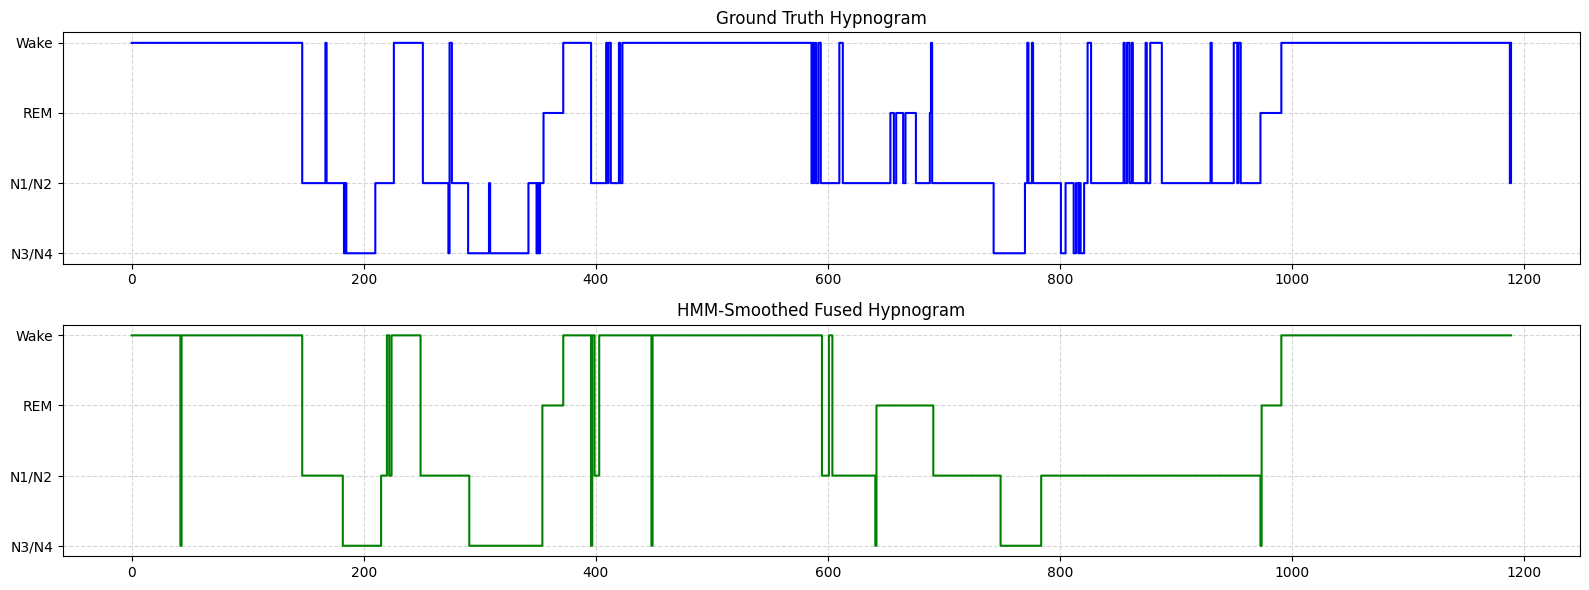

In [ ]:
#Step 3 - Late fusion and final prediction 
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from timesformer_pytorch import TimeSformer
from hmmlearn import hmm
from hmmlearn.hmm import MultinomialHMM

# === Settings ===
participant_npz_path = "" #Path to participant tensor (.npz format)
ground_truth_csv_path = "" #Path to ground truth csv
lstm_predictions_csv_path = "participant_predictions.csv"

# === 1. TimeSformer Inference ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TimeSformer(
    dim=256,
    image_size=224,
    patch_size=16,
    num_frames=4,
    num_classes=4,
    depth=4,
    heads=2,
    dim_head=64,
    attn_dropout=0.5,
    ff_dropout=0.5
)
model.load_state_dict(torch.load('TimeSformer_Model.pt', map_location=device))
model.to(device)
model.eval()

npz_data = np.load(participant_npz_path)
participant_tensor = torch.tensor(npz_data['data'], dtype=torch.float32).to(device)

window_size = 54
stride = 40
batch_size = 8
num_classes = 4
T = participant_tensor.shape[0]
vote_scores = torch.zeros((T, num_classes), device=device)

with torch.no_grad():
    for start in range(0, T - window_size + 1, stride):
        end = start + window_size
        chunk = participant_tensor[start:end]

        chunk_probs = []
        for batch_start in range(0, chunk.shape[0], batch_size):
            batch_end = min(batch_start + batch_size, chunk.shape[0])
            batch_data = chunk[batch_start:batch_end]
            outputs = model(batch_data)
            probs = F.softmax(outputs, dim=1)
            chunk_probs.append(probs)

        chunk_probs = torch.cat(chunk_probs, dim=0)
        vote_scores[start:end] += chunk_probs

timesformer_probs = vote_scores.softmax(dim=1).detach().cpu()

# === 2. LSTM Inference from CSV ===
lstm_df = pd.read_csv(lstm_predictions_csv_path)
lstm_stage_map = {'Wake': 0, 'N1/N2': 1, 'N3/N4': 2, 'REM': 3}
lstm_indices = [lstm_stage_map[label] for label in lstm_df['Predicted Sleep Stage'].tolist()]
lstm_tensor = torch.tensor(lstm_indices)
lstm_probs = F.one_hot(lstm_tensor, num_classes=4).float().repeat_interleave(10, dim=0)

# === 3. Match lengths ===
min_len = min(timesformer_probs.shape[0], lstm_probs.shape[0])
timesformer_probs = timesformer_probs[:min_len]
lstm_probs = lstm_probs[:min_len]

# === 4. Per-Class Weighted Fusion ===
alpha_per_class = torch.tensor([1, 1, 1, 1], device=timesformer_probs.device).unsqueeze(0)  #Change per class weight if needed
beta_per_class = 1.0 - alpha_per_class

fused_probs = alpha_per_class * timesformer_probs + beta_per_class * lstm_probs

fused_preds = torch.argmax(fused_probs, dim=1).numpy()

# === 5. HMM ===
trans_mat = np.array([
    [0.628, 0.017, 0.348, 0.007],
    [0.016, 0.949, 0.035, 0.000],
    [0.0475, 0.0275, 0.894, 0.031],
    [0.011, 0.002, 0.109, 0.878]
])

start_probs = np.array([0.25, 0.25, 0.25, 0.25])

model_hmm = MultinomialHMM(n_components=4, init_params="", n_trials=10)
model_hmm.startprob_ = start_probs
model_hmm.transmat_ = trans_mat
model_hmm.emissionprob_ = np.full((4, 4), 0.1)
np.fill_diagonal(model_hmm.emissionprob_, 0.7)

fused_obs = fused_probs.numpy() 

# Convert to "counts" for MultinomialHMM
fused_obs_counts = np.round(fused_obs * 10).astype(int)
smoothed_preds = model_hmm.predict(fused_obs_counts)


# === 6. Load and align Ground Truth ===
gt_df = pd.read_csv(ground_truth_csv_path)
numeric_to_class = {0.0: 0, 1.0: 1, 2.0: 2, 3.0: 3}
gt_raw = gt_df['sleepstage'].tolist()
gt_labels = [numeric_to_class.get(float(lbl), -1) for lbl in gt_raw]
gt_labels_filtered = [gt_labels[i] for i in range(len(gt_labels)) if gt_labels[i] != -1]

# Truncate all to match
min_len_final = min(len(gt_labels_filtered), len(smoothed_preds))
gt_labels_final = gt_labels_filtered[:min_len_final]
smoothed_preds_final = smoothed_preds[:min_len_final]

# === 7. Hypnogram Plotting ===
stage_order = ['Wake', 'REM', 'N1/N2', 'N3/N4']
stage_map = {0: 'Wake', 1: 'N1/N2', 2: 'N3/N4', 3: 'REM'}
stage_to_num = {stage: i for i, stage in enumerate(stage_order[::-1])}

smoothed_stage_labels = [stage_map[p] for p in smoothed_preds_final]
gt_stage_labels = [stage_map[p] for p in gt_labels_final]

numeric_smoothed = [stage_to_num[s] for s in smoothed_stage_labels]
numeric_gt = [stage_to_num[s] for s in gt_stage_labels]

plt.figure(figsize=(16, 6))
plt.subplot(2, 1, 1)
plt.step(range(len(numeric_gt)), numeric_gt, where='post', color='blue')
plt.yticks(range(len(stage_order)), stage_order[::-1])
plt.title("Ground Truth Hypnogram")
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(2, 1, 2)
plt.step(range(len(numeric_smoothed)), numeric_smoothed, where='post', color='green')
plt.yticks(range(len(stage_order)), stage_order[::-1])
plt.title("HMM-Smoothed Fused Hypnogram")
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
